# Installs

In [ ]:
!pip install "numpy<2.0"
!pip install torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118

!pip install torch_geometric


Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 528.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6.0+cu124
    Uninstalling torch-2.6.0+cu124:
      Successfully uninstalled torch-2.6.0+cu124
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.21.0+cu124
    Uninstalling torchvision-0.21.0+cu124:
      Successfully uninstalled torchvision-0.21.0+cu124
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.6.0+cu124
    Uninstalling tor

In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.6 MB/s eta 0:00:00


# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphSAGE, GCNConv, GATConv, GINConv, LayerNorm, BatchNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool, global_sort_pool
from torch_geometric.data import DataLoader
from torch_geometric.nn.aggr import SumAggregation, MeanAggregation, MaxAggregation, StdAggregation

import numpy as np
import pandas as pd
import time
import psutil
import os
import pickle
from typing import Dict, List, Tuple, Any
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import StratifiedKFold
import warnings
from torch_geometric.datasets import TUDataset
from sklearn.model_selection import ParameterSampler

warnings.filterwarnings('ignore')

# Bayesian Optimization imports
try:
    from skopt import gp_minimize
    from skopt.space import Real, Integer, Categorical
    from skopt.utils import use_named_args
    from skopt.acquisition import gaussian_ei
    BAYESIAN_OPT_AVAILABLE = True
except ImportError:
    print("Warning: scikit-optimize not available. Please install with: pip install scikit-optimize")
    BAYESIAN_OPT_AVAILABLE = False

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool, global_add_pool
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, BatchNorm, LayerNorm
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import psutil
import pickle
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Configurations

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


# Loading the dataset

1. **Nodes**: Amino acids.
2. **Edges**: Connections between amino acids that are within 6 Ångströms of each other.
3. **Labels**: Binary classification indicating whether a protein is an enzyme or not.

Clarification:
1. The 89 features are node features, not graph-level features (Structural information, Chemical properties)


In [ ]:
print("Loading DD dataset...")
dataset = TUDataset(root='/tmp/DD', name='DD')

print(f"Dataset: {dataset}")
print(f"Number of graphs: {len(dataset)}")
print(f"Number of features: {dataset.num_features}")
print(f"Number of classes: {dataset.num_classes}")

# Get first graph for exploration
data = dataset[0]
print(f"\nFirst graph:")
print(f"Number of nodes: {data.x.shape[0]}")
print(f"Number of edges: {data.edge_index.shape[1]}")
print(f"Node feature shape: {data.x.shape}")
print(f"Label: {data.y}")

Loading DD dataset...


Processing...


Dataset: DD(1178)
Number of graphs: 1178
Number of features: 89
Number of classes: 2

First graph:
Number of nodes: 327
Number of edges: 1798
Node feature shape: torch.Size([327, 89])
Label: tensor([0])


Done!


# DATA PREPROCESSING

In [ ]:
data_list = [data for data in dataset]

## splitting

In [ ]:
from sklearn.model_selection import train_test_split

labels = [data.y.item() for data in data_list]
all_indices = list(range(len(data_list)))

# First split: 60% train, 40% (val+test)
train_idx, temp_idx = train_test_split(
    all_indices,
    test_size=0.4,
    stratify=labels,
    random_state=42
)

# Second split: 20% val, 20% test from the remaining 40%
# So test_size=0.5 here means 50% of the 40% => 20% of the total
temp_labels = [labels[i] for i in temp_idx]
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)


In [ ]:
print(f"Train set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")
print(f"Test set size: {len(test_idx)}")


Train set size: 706
Validation set size: 236
Test set size: 236


In [ ]:
train_dataset = [data_list[i] for i in train_idx]
val_dataset = [data_list[i] for i in val_idx]
test_dataset = [data_list[i] for i in test_idx]

# data loaders

In [ ]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nBatch size: {batch_size}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")


Batch size: 32
Number of training batches: 23
Number of validation batches: 8
Number of test batches: 8


# TRAINING UTILITIES

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_memory_usage():
    """Get current memory usage"""
    process = psutil.Process()
    cpu_memory = process.memory_info().rss / 1024 / 1024  # MB
    gpu_memory = 0
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.memory_allocated() / 1024 / 1024  # MB
    return cpu_memory, gpu_memory

def measure_inference_time(model, loader, device, num_samples=100):
    model.eval()
    times = []
    with torch.no_grad():
        for i, batch in enumerate(loader):
            if i * batch.y.size(0) >= num_samples:
                break
            batch = batch.to(device)
            start_time = time.time()
            _ = model(batch.x, batch.edge_index, batch.batch)
            end_time = time.time()
            batch_time = (end_time - start_time) / batch.y.size(0)
            times.append(batch_time)
    return np.mean(times) * 1000  # Convert to milliseconds


# Model definition: GINModel

In [ ]:
class GINModel(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers,
                 dropout=0.3, global_pool='mean', eps=0.0, train_eps=False,
                 batch_norm=True, layer_norm=False):
        super().__init__()
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList() if batch_norm else None
        self.layer_norms = nn.ModuleList() if layer_norm else None

        # First layer
        mlp = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Hidden layers
        for _ in range(num_layers - 2):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Last layer
        if num_layers > 1:
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            )
            self.convs.append(GINConv(mlp, eps=eps, train_eps=train_eps))

        # Normalization layers
        if batch_norm:
            for _ in range(num_layers):
                self.batch_norms.append(BatchNorm(hidden_dim))
        if layer_norm:
            for _ in range(num_layers):
                self.layer_norms.append(LayerNorm(hidden_dim))

        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

        # Global pooling
        self.global_pool = {
            'mean': global_mean_pool,
            'max': global_max_pool,
            'add': global_add_pool
        }[global_pool]

    def forward(self, x, edge_index, batch):
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if self.batch_norms:
                x = self.batch_norms[i](x)
            if self.layer_norms:
                x = self.layer_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        # Last layer
        if len(self.convs) > 0:
            x = self.convs[-1](x, edge_index)
            if self.batch_norms and len(self.batch_norms) > len(self.convs) - 1:
                x = self.batch_norms[-1](x)
            if self.layer_norms and len(self.layer_norms) > len(self.convs) - 1:
                x = self.layer_norms[-1](x)

        x = self.global_pool(x, batch)
        return self.classifier(x)

# Evalutation of model

In [ ]:
def evaluate(model, loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            correct += (pred == batch.y).sum().item()
            total += batch.y.size(0)
    return correct / total

def evaluate_detailed(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch.x, batch.edge_index, batch.batch).argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds, average='binary'),
        'precision': precision_score(all_labels, all_preds, average='binary'),
        'recall': recall_score(all_labels, all_preds, average='binary'),
        'predictions': all_preds,
        'labels': all_labels
    }


# Training and evalutation function

In [ ]:
def train_evaluate(model, train_loader, val_loader, test_loader, device, epochs=100, plot_training=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    # For plotting and peak memory tracking
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    epoch_times = []
    peak_train_cpu = peak_train_gpu = 0
    peak_inf_cpu = peak_inf_gpu = 0

    for epoch in range(epochs):
        epoch_start = time.time()

        # Train with peak memory tracking
        model.train()
        epoch_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Track peak memory during training
        cpu_mem, gpu_mem = get_memory_usage()
        peak_train_cpu = max(peak_train_cpu, cpu_mem)
        peak_train_gpu = max(peak_train_gpu, gpu_mem)

        epoch_time = time.time() - epoch_start
        epoch_times.append(epoch_time)

        # Validate every 10 epochs
        if epoch % 10 == 0:
            val_acc = evaluate(model, val_loader, device)
            train_acc = evaluate(model, train_loader, device)
            val_loss = evaluate_loss(model, val_loader, device, criterion)

            train_losses.append(epoch_loss / len(train_loader))
            val_losses.append(val_loss)
            train_accs.append(train_acc)
            val_accs.append(val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= 5:  # Early stopping
                break

    training_time = time.time() - start_time

    # Plot training curves for best model
    if plot_training:
        plt.figure(figsize=(15, 5))
        epochs_range = range(0, len(train_losses) * 10, 10)

        plt.subplot(1, 3, 1)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.plot(epochs_range, val_losses, 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train vs Validation Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, train_accs, 'b-', label='Train Accuracy')
        plt.plot(epochs_range, val_accs, 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Train vs Validation Accuracy')
        plt.legend()

        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, train_losses, 'b-', label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Peak memory during inference
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            _ = model(batch.x, batch.edge_index, batch.batch)
            cpu_mem, gpu_mem = get_memory_usage()
            peak_inf_cpu = max(peak_inf_cpu, cpu_mem)
            peak_inf_gpu = max(peak_inf_gpu, gpu_mem)

    metrics = evaluate_detailed(model, test_loader, device)
    inference_time = measure_inference_time(model, test_loader, device)

    metrics.update({
        'training_time': training_time,
        'avg_epoch_time': np.mean(epoch_times),
        'parameters': count_parameters(model),
        'peak_train_cpu_mb': peak_train_cpu,
        'peak_train_gpu_mb': peak_train_gpu,
        'peak_inf_cpu_mb': peak_inf_cpu,
        'peak_inf_gpu_mb': peak_inf_gpu,
        'inference_time_ms': inference_time
    })

    return metrics

# Helper function for validation loss


In [ ]:
def evaluate_loss(model, loader, device, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()
    return total_loss / len(loader)

# Optimize the model

In [ ]:
def train_evaluate_mixed_precision(model, train_loader, val_loader, test_loader, device,
                                 precision='32', epochs=80, patience=10):
    """Train and evaluate model with specified precision"""

    # Set model precision
    if precision == '16':
        model = model.half()  # Convert to FP16
        use_amp = True
        scaler = GradScaler()
    elif precision == '32':
        model = model.float()  # Ensure FP32
        use_amp = False
        scaler = None
    else:  # Original (mixed precision with autocast)
        use_amp = True
        scaler = GradScaler()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

    # Training metrics tracking
    train_losses = []
    val_losses = []
    val_accuracies = []
    memory_usage = []

    best_val_acc = 0
    patience_counter = 0
    start_time = time.time()

    model.train()
    for epoch in range(epochs):
        epoch_start = time.time()
        total_loss = 0
        num_batches = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            # Forward pass with appropriate precision
            if use_amp and precision != '16':  # Original mixed precision
                with autocast():
                    out = model(batch.x, batch.edge_index, batch.batch)
                    loss = criterion(out, batch.y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            elif precision == '16':  # Pure FP16
                # Convert inputs to half precision
                batch.x = batch.x.half()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()
            else:  # FP32
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)

                if precision == '16':
                    batch.x = batch.x.half()
                    out = model(batch.x, batch.edge_index, batch.batch)
                elif use_amp and precision != '16':
                    with autocast():
                        out = model(batch.x, batch.edge_index, batch.batch)
                else:
                    out = model(batch.x, batch.edge_index, batch.batch)

                val_loss += criterion(out, batch.y).item()
                pred = out.argmax(dim=1)
                correct += (pred == batch.y).sum().item()
                total += batch.y.size(0)

        val_acc = correct / total
        avg_train_loss = total_loss / num_batches
        avg_val_loss = val_loss / len(val_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)

        # Memory tracking
        cpu_mem, gpu_mem = get_memory_usage()
        memory_usage.append({'epoch': epoch, 'cpu_mb': cpu_mem, 'gpu_mb': gpu_mem})

        scheduler.step(avg_val_loss)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

        model.train()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    training_time = time.time() - start_time

    # Final evaluation on test set
    model.eval()
    test_preds = []
    test_labels = []
    inference_times = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            inf_start = time.time()
            if precision == '16':
                batch.x = batch.x.half()
                out = model(batch.x, batch.edge_index, batch.batch)
            elif use_amp and precision != '16':
                with autocast():
                    out = model(batch.x, batch.edge_index, batch.batch)
            else:
                out = model(batch.x, batch.edge_index, batch.batch)
            inf_time = (time.time() - inf_start) * 1000  # ms

            pred = out.argmax(dim=1)
            test_preds.extend(pred.cpu().numpy())
            test_labels.extend(batch.y.cpu().numpy())
            inference_times.append(inf_time)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

    accuracy = accuracy_score(test_labels, test_preds)
    f1 = f1_score(test_labels, test_preds, average='weighted')
    precision = precision_score(test_labels, test_preds, average='weighted')
    recall = recall_score(test_labels, test_preds, average='weighted')

    # Model parameters
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    # Peak memory usage
    peak_cpu = max([m['cpu_mb'] for m in memory_usage])
    peak_gpu = max([m['gpu_mb'] for m in memory_usage])

    avg_inference_time = np.mean(inference_times)

    metrics = {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'parameters': num_params,
        'training_time': training_time,
        'avg_time_per_epoch': training_time / (epoch + 1),
        'inference_time_ms': avg_inference_time,
        'peak_memory_cpu_mb': peak_cpu,
        'peak_memory_gpu_mb': peak_gpu,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'memory_usage': memory_usage,
        'final_epoch': epoch
    }

    return metrics

In [ ]:
def run_precision_comparison(dataset, train_loader, val_loader, test_loader, device):
    """Compare different precision modes"""

    # Best configuration from your results
    best_config = {
        'train_eps': True,
        'num_layers': 4,
        'layer_norm': True,
        'hidden_dim': 128,
        'global_pool': 'max',
        'eps': 0.0,
        'dropout': 0.5,
        'batch_norm': False
    }

    print("=" * 80)
    print("MIXED PRECISION COMPARISON FOR BEST GIN MODEL")
    print("=" * 80)
    print(f"Configuration: {best_config}")
    print("=" * 80)

    results = {}
    models = {}

    # Test different precision modes
    precision_modes = ['32', '16', 'mixed']
    precision_names = ['FP32 (32-bit)', 'FP16 (16-bit)', 'Mixed Precision (Original)']

    for precision, name in zip(precision_modes, precision_names):
        print(f"\n{'='*20} {name} {'='*20}")

        # Create model
        model = GINModel(
            num_features=dataset.num_features,
            num_classes=dataset.num_classes,
            **best_config
        ).to(device)

        # Train and evaluate
        metrics = train_evaluate_mixed_precision(
            model, train_loader, val_loader, test_loader, device, precision=precision
        )

        results[precision] = metrics
        models[precision] = model

        # Print results
        print(f"\nResults for {name}:")
        print(f"  Accuracy: {metrics['accuracy']:.4f}")
        print(f"  F1-Score: {metrics['f1']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall: {metrics['recall']:.4f}")
        print(f"  Parameters: {metrics['parameters']:,}")
        print(f"  Training Time: {metrics['training_time']:.2f}s")
        print(f"  Avg Time/Epoch: {metrics['avg_time_per_epoch']:.2f}s")
        print(f"  Inference Time: {metrics['inference_time_ms']:.2f}ms")
        print(f"  Peak CPU Memory: {metrics['peak_memory_cpu_mb']:.1f} MB")
        print(f"  Peak GPU Memory: {metrics['peak_memory_gpu_mb']:.1f} MB")
        print(f"  Final Epoch: {metrics['final_epoch']}")

    # Create comprehensive comparison
    print("\n" + "=" * 80)
    print("COMPREHENSIVE COMPARISON TABLE")
    print("=" * 80)

    # Create comparison DataFrame
    comparison_data = []
    for precision, name in zip(precision_modes, precision_names):
        metrics = results[precision]
        comparison_data.append({
            'Precision': name,
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1'],
            'Precision_Score': metrics['precision'],
            'Recall': metrics['recall'],
            'Training_Time_s': metrics['training_time'],
            'Inference_Time_ms': metrics['inference_time_ms'],
            'Peak_CPU_MB': metrics['peak_memory_cpu_mb'],
            'Peak_GPU_MB': metrics['peak_memory_gpu_mb'],
            'Parameters': metrics['parameters'],
            'Final_Epoch': metrics['final_epoch']
        })

    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.round(4).to_string(index=False))

    # Calculate speedup and memory savings
    print("\n" + "=" * 80)
    print("PERFORMANCE ANALYSIS")
    print("=" * 80)

    fp32_time = results['32']['training_time']
    fp16_time = results['16']['training_time']
    mixed_time = results['mixed']['training_time']

    fp32_memory = results['32']['peak_memory_gpu_mb']
    fp16_memory = results['16']['peak_memory_gpu_mb']
    mixed_memory = results['mixed']['peak_memory_gpu_mb']

    print(f"Training Time Speedup:")
    print(f"  FP16 vs FP32: {fp32_time/fp16_time:.2f}x faster")
    print(f"  Mixed vs FP32: {fp32_time/mixed_time:.2f}x faster")
    print(f"  FP16 vs Mixed: {mixed_time/fp16_time:.2f}x faster")

    print(f"\nGPU Memory Savings:")
    print(f"  FP16 vs FP32: {(1-fp16_memory/fp32_memory)*100:.1f}% reduction")
    print(f"  Mixed vs FP32: {(1-mixed_memory/fp32_memory)*100:.1f}% reduction")

    print(f"\nAccuracy Trade-offs:")
    fp32_acc = results['32']['accuracy']
    fp16_acc = results['16']['accuracy']
    mixed_acc = results['mixed']['accuracy']

    print(f"  FP16 vs FP32: {(fp16_acc-fp32_acc)*100:+.2f}% accuracy change")
    print(f"  Mixed vs FP32: {(mixed_acc-fp32_acc)*100:+.2f}% accuracy change")

    # Create comprehensive visualization
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))

    # 1. Performance Metrics Comparison
    metrics_names = ['Accuracy', 'F1-Score', 'Precision_Score', 'Recall']
    metrics_data = df_comparison[metrics_names].values.T

    x = np.arange(len(precision_names))
    width = 0.2

    for i, metric in enumerate(metrics_names):
        axes[0, 0].bar(x + i*width, metrics_data[i], width, label=metric)
    axes[0, 0].set_xlabel('Precision Mode')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Performance Metrics Comparison')
    axes[0, 0].set_xticks(x + width * 1.5)
    axes[0, 0].set_xticklabels(precision_names, rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Training Time Comparison
    training_times = [results[p]['training_time'] for p in precision_modes]
    bars = axes[0, 1].bar(precision_names, training_times, color=['blue', 'red', 'green'])
    axes[0, 1].set_ylabel('Training Time (seconds)')
    axes[0, 1].set_title('Training Time Comparison')
    axes[0, 1].grid(True, alpha=0.3)

    # Add values on bars
    for bar, time in zip(bars, training_times):
        axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{time:.1f}s', ha='center', va='bottom')

    # 3. Memory Usage Comparison
    cpu_memory = [results[p]['peak_memory_cpu_mb'] for p in precision_modes]
    gpu_memory = [results[p]['peak_memory_gpu_mb'] for p in precision_modes]

    x = np.arange(len(precision_names))
    width = 0.35

    axes[0, 2].bar(x - width/2, cpu_memory, width, label='CPU Memory', alpha=0.7)
    axes[0, 2].bar(x + width/2, gpu_memory, width, label='GPU Memory', alpha=0.7)
    axes[0, 2].set_xlabel('Precision Mode')
    axes[0, 2].set_ylabel('Memory Usage (MB)')
    axes[0, 2].set_title('Peak Memory Usage Comparison')
    axes[0, 2].set_xticks(x)
    axes[0, 2].set_xticklabels(precision_names, rotation=45)
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Training Loss Curves
    for precision, name in zip(precision_modes, precision_names):
        epochs = range(len(results[precision]['train_losses']))
        axes[1, 0].plot(epochs, results[precision]['train_losses'], label=f'{name} Train')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Training Loss Curves')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. Validation Loss Curves
    for precision, name in zip(precision_modes, precision_names):
        epochs = range(len(results[precision]['val_losses']))
        axes[1, 1].plot(epochs, results[precision]['val_losses'], label=f'{name} Val')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Validation Loss Curves')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Validation Accuracy Curves
    for precision, name in zip(precision_modes, precision_names):
        epochs = range(len(results[precision]['val_accuracies']))
        axes[1, 2].plot(epochs, results[precision]['val_accuracies'], label=f'{name}')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Validation Accuracy')
    axes[1, 2].set_title('Validation Accuracy Curves')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    # 7. Inference Time Comparison
    inference_times = [results[p]['inference_time_ms'] for p in precision_modes]
    bars = axes[2, 0].bar(precision_names, inference_times, color=['blue', 'red', 'green'])
    axes[2, 0].set_ylabel('Inference Time (ms)')
    axes[2, 0].set_title('Inference Time Comparison')
    axes[2, 0].grid(True, alpha=0.3)

    for bar, time in zip(bars, inference_times):
        axes[2, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                       f'{time:.2f}ms', ha='center', va='bottom')

    # 8. Memory Usage Over Time (GPU)
    for precision, name in zip(precision_modes, precision_names):
        memory_data = results[precision]['memory_usage']
        epochs = [m['epoch'] for m in memory_data]
        gpu_mem = [m['gpu_mb'] for m in memory_data]
        axes[2, 1].plot(epochs, gpu_mem, label=name, marker='o', markersize=2)
    axes[2, 1].set_xlabel('Epoch')
    axes[2, 1].set_ylabel('GPU Memory (MB)')
    axes[2, 1].set_title('GPU Memory Usage Over Time')
    axes[2, 1].legend()
    axes[2, 1].grid(True, alpha=0.3)

    # 9. Efficiency Scatter Plot (Accuracy vs Training Time)
    accuracies = [results[p]['accuracy'] for p in precision_modes]
    times = [results[p]['training_time'] for p in precision_modes]
    colors = ['blue', 'red', 'green']

    for i, (acc, time, name, color) in enumerate(zip(accuracies, times, precision_names, colors)):
        axes[2, 2].scatter(time, acc, s=100, c=color, label=name, alpha=0.7)
        axes[2, 2].annotate(name, (time, acc), xytext=(5, 5),
                           textcoords='offset points', fontsize=8)

    axes[2, 2].set_xlabel('Training Time (seconds)')
    axes[2, 2].set_ylabel('Accuracy')
    axes[2, 2].set_title('Efficiency: Accuracy vs Training Time')
    axes[2, 2].grid(True, alpha=0.3)
    axes[2, 2].legend()

    plt.tight_layout()
    plt.savefig('mixed_precision_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save detailed results
    with open('mixed_precision_results.pkl', 'wb') as f:
        pickle.dump({
            'results': results,
            'comparison_df': df_comparison,
            'best_config': best_config
        }, f)

    df_comparison.to_csv('mixed_precision_comparison.csv', index=False)

    # Save best models
    for precision in precision_modes:
        torch.save(models[precision].state_dict(), f'best_gin_model_{precision}bit.pth')

    print(f"\nFiles saved:")
    print(f"  - mixed_precision_comparison.png")
    print(f"  - mixed_precision_comparison.csv")
    print(f"  - mixed_precision_results.pkl")
    print(f"  - best_gin_model_32bit.pth")
    print(f"  - best_gin_model_16bit.pth")
    print(f"  - best_gin_model_mixedbit.pth")

    return results, df_comparison

# Original model metrics for comparison (your baseline)
original_metrics = {
    'accuracy': 0.7585,
    'f1': 0.7164,
    'precision': 0.6923,
    'recall': 0.7423,
    'parameters': 128390,
    'training_time': 26.79,
    'avg_time_per_epoch': 0.34,
    'inference_time_ms': 0.11,
    'peak_memory_cpu_mb': 1326.5,
    'peak_memory_gpu_mb': 23.9
}


In [ ]:
def compare_with_original(results, original_metrics):
    """Compare new results with original baseline"""
    print("\n" + "=" * 80)
    print("COMPARISON WITH ORIGINAL MODEL")
    print("=" * 80)

    comparison_data = []

    # Add original metrics
    comparison_data.append({
        'Model': 'Original',
        'Accuracy': original_metrics['accuracy'],
        'F1-Score': original_metrics['f1'],
        'Training_Time_s': original_metrics['training_time'],
        'Inference_Time_ms': original_metrics['inference_time_ms'],
        'Peak_GPU_MB': original_metrics['peak_memory_gpu_mb']
    })

    # Add new results
    precision_names = ['FP32 (32-bit)', 'FP16 (16-bit)', 'Mixed Precision']
    for precision, name in zip(['32', '16', 'mixed'], precision_names):
        metrics = results[precision]
        comparison_data.append({
            'Model': name,
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1'],
            'Training_Time_s': metrics['training_time'],
            'Inference_Time_ms': metrics['inference_time_ms'],
            'Peak_GPU_MB': metrics['peak_memory_gpu_mb']
        })

    df_final = pd.DataFrame(comparison_data)
    print(df_final.round(4).to_string(index=False))

    # Performance improvements
    print(f"\nPerformance vs Original:")
    for precision, name in zip(['32', '16', 'mixed'], precision_names):
        metrics = results[precision]
        acc_change = (metrics['accuracy'] - original_metrics['accuracy']) * 100
        time_change = (metrics['training_time'] - original_metrics['training_time']) / original_metrics['training_time'] * 100
        mem_change = (metrics['peak_memory_gpu_mb'] - original_metrics['peak_memory_gpu_mb']) / original_metrics['peak_memory_gpu_mb'] * 100

        print(f"  {name}:")
        print(f"    Accuracy: {acc_change:+.2f}%")
        print(f"    Training Time: {time_change:+.1f}%")
        print(f"    GPU Memory: {mem_change:+.1f}%")

    return df_final

MIXED PRECISION COMPARISON FOR BEST GIN MODEL
Configuration: {'train_eps': True, 'num_layers': 4, 'layer_norm': True, 'hidden_dim': 128, 'global_pool': 'max', 'eps': 0.0, 'dropout': 0.5, 'batch_norm': False}

==================== FP32 (32-bit) ====================
Epoch 0: Train Loss: 0.6613, Val Loss: 0.6988, Val Acc: 0.5847
Epoch 10: Train Loss: 0.5237, Val Loss: 0.5765, Val Acc: 0.7076
Epoch 20: Train Loss: 0.4687, Val Loss: 0.6158, Val Acc: 0.6907
Early stopping at epoch 22

Results for FP32 (32-bit):
  Accuracy: 0.7669
  F1-Score: 0.7664
  Precision: 0.7660
  Recall: 0.7669
  Parameters: 128,390
  Training Time: 9.72s
  Avg Time/Epoch: 0.42s
  Inference Time: 3.41ms
  Peak CPU Memory: 1232.7 MB
  Peak GPU Memory: 19.4 MB
  Final Epoch: 22

==================== FP16 (16-bit) ====================
Epoch 0: Train Loss: nan, Val Loss: nan, Val Acc: 0.5847
Early stopping at epoch 10

Results for FP16 (16-bit):
  Accuracy: 0.5890
  F1-Score: 0.4366
  Precision: 0.3469
  Recall: 0.5890
  

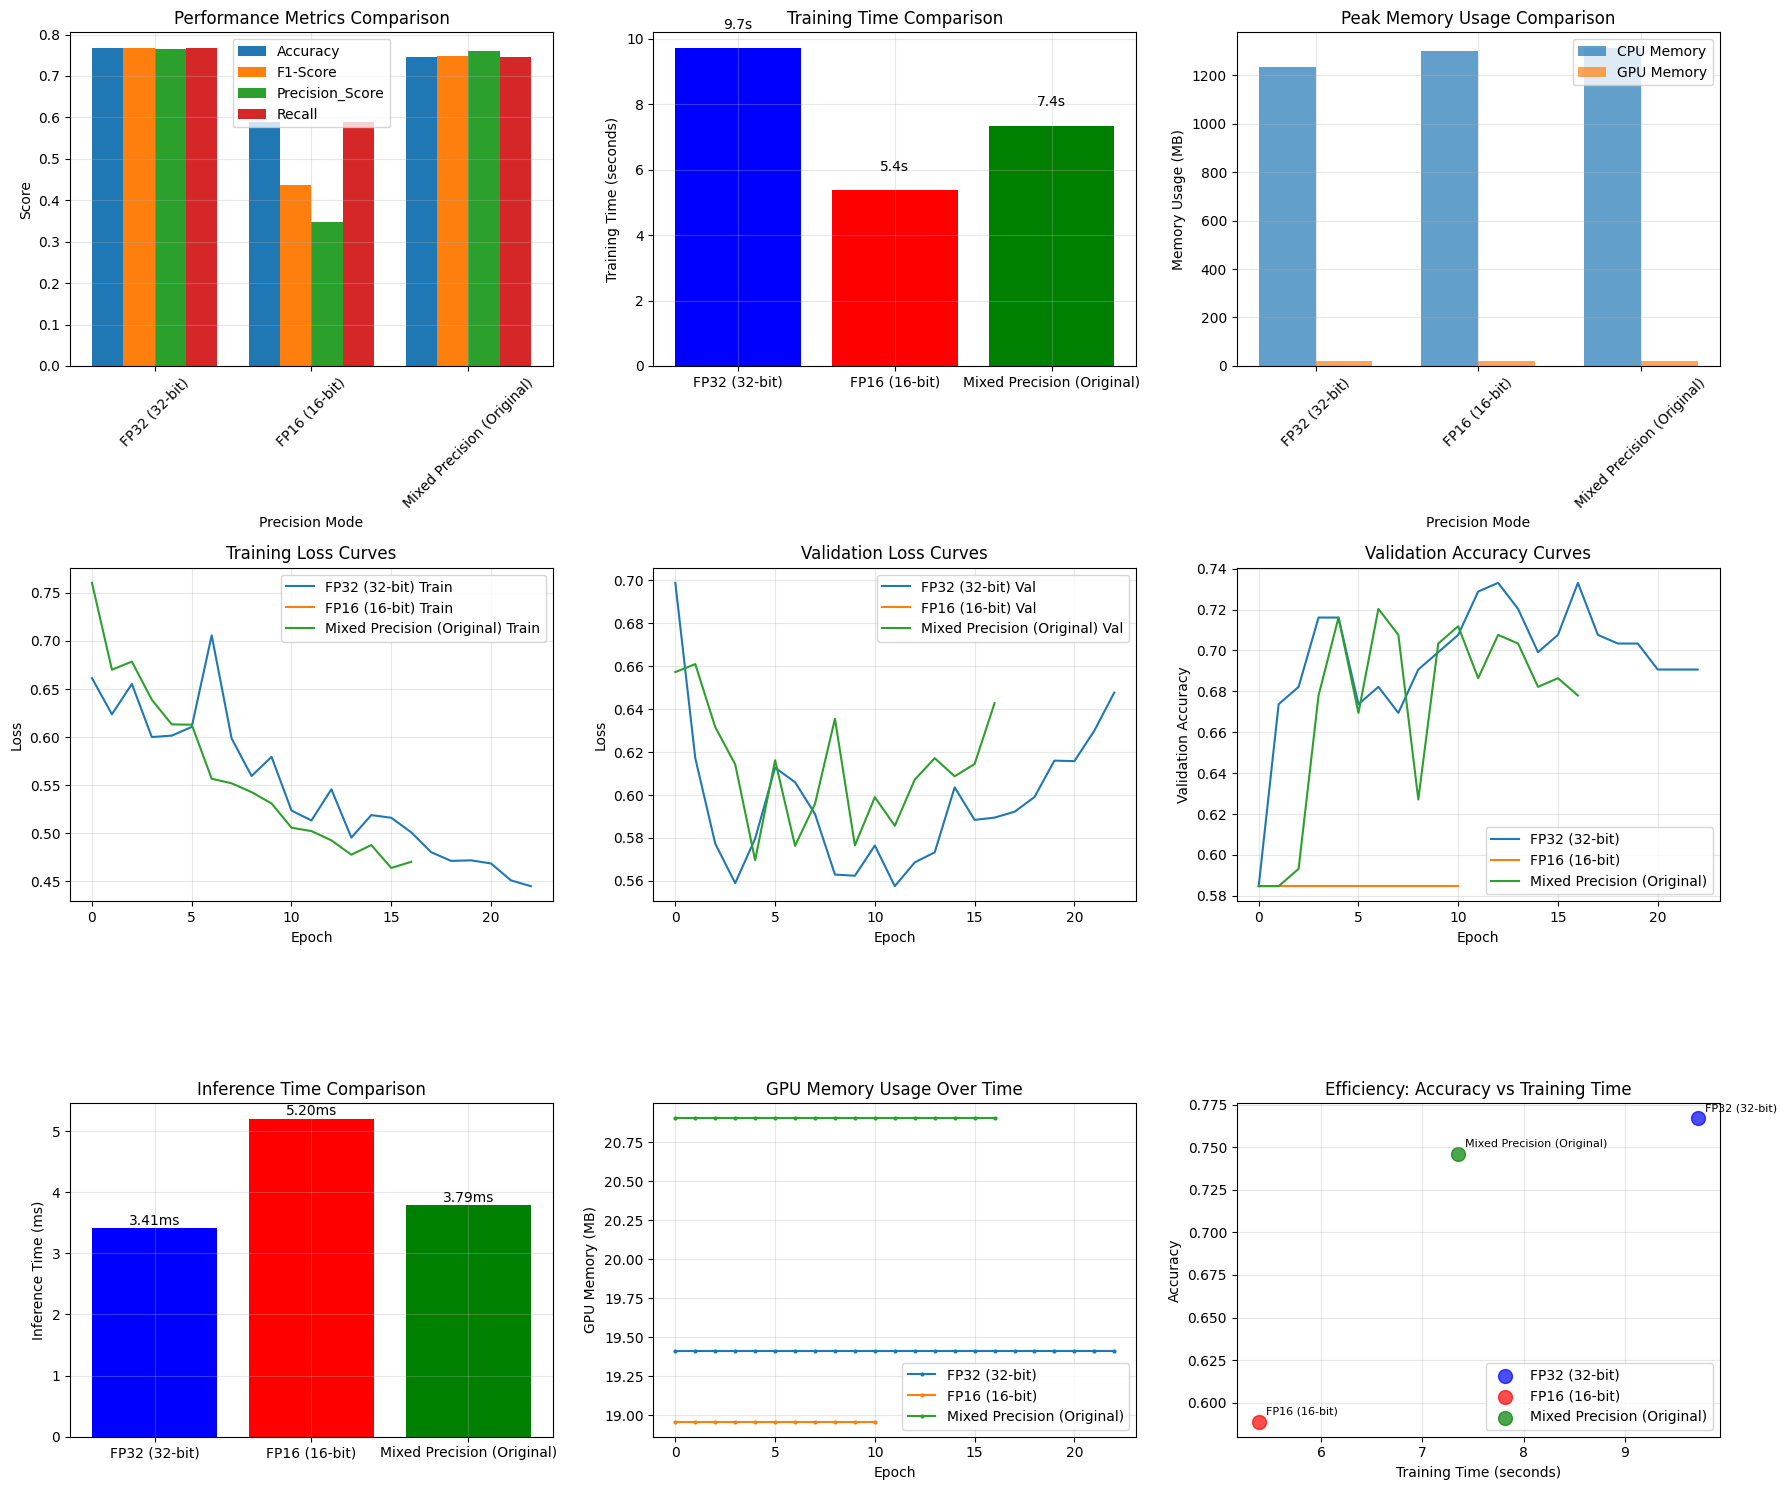


Files saved:
  - mixed_precision_comparison.png
  - mixed_precision_comparison.csv
  - mixed_precision_results.pkl
  - best_gin_model_32bit.pth
  - best_gin_model_16bit.pth
  - best_gin_model_mixedbit.pth


In [ ]:
results, comparison_df = run_precision_comparison(dataset, train_loader, val_loader, test_loader, device)

In [ ]:
final_comparison = compare_with_original(results, original_metrics)


COMPARISON WITH ORIGINAL MODEL
          Model  Accuracy  F1-Score  Training_Time_s  Inference_Time_ms  Peak_GPU_MB
       Original    0.7585    0.7164          26.7900             0.1100      23.9000
  FP32 (32-bit)    0.7669    0.7664           9.7172             3.4100      19.4141
  FP16 (16-bit)    0.5890    0.4366           5.3834             5.1966      18.9600
Mixed Precision    0.7458    0.7478           7.3523             3.7859      20.9023

Performance vs Original:
  FP32 (32-bit):
    Accuracy: +0.84%
    Training Time: -63.7%
    GPU Memory: -18.8%
  FP16 (16-bit):
    Accuracy: -16.95%
    Training Time: -79.9%
    GPU Memory: -20.7%
  Mixed Precision:
    Accuracy: -1.27%
    Training Time: -72.6%
    GPU Memory: -12.5%
